In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
from jax import grad, vmap, jit
from functools import partial
from jax.flatten_util import ravel_pytree
import jax.random as random
from jax.lax import cond, scan
import jax.example_libraries.optimizers as optimizers
key = random.PRNGKey(2022)

from utils_node import init_params_damage
from utils_node import RK_forward_pass_nobias as NODE_nobias, RK_forward_pass as NODE

import matplotlib.pyplot as plt
import pandas as pd
import pickle

import diffrax
from diffrax import diffeqsolve, ODETerm, SaveAt#, Heun as mysolver
from diffrax import Dopri5 as mysolver
from diffrax import Heun as mysolver

In [2]:
n_damage = 1

def f(d, params):
    return jnp.exp(-1*NODE_nobias(d, params))
    # return 1.0-d
f_vmap = vmap(f, in_axes=(0, None))
def G(tau, params):
    return NODE(tau, params)
G_vmap = vmap(G, in_axes=(0, None))

In [3]:
@jit
def ddot_fn(params, y, Psi_list, Psidot_list):
    params_Psi_list, params_f_list, params_G_list = params
    ddot_list = []
    rdot_list = []
    for i in range(n_damage):
        Psi0        = Psi_list[i]
        Psi0dot     = Psidot_list[i]
        di          = y[i]
        ri          = y[n_damage+i]
        params_f    = params_f_list[i]
        params_G    = params_G_list[i]

        dfdd = grad(f)(di, params_f)
        taui = -Psi0*dfdd

        #check if g<0
        g = G(taui, params_G) - G(ri, params_G)
        def true_fun(): #What to return for rdot & ddot if g<0
            return 0.0, 0.0
        def false_fun():
            dGdtau = grad(G)(taui, params_G)
            d2fdd2 = grad(grad(f))(di, params_f)
            ddot = -(Psi0dot*dfdd*dGdtau)/(1+Psi0*d2fdd2*dGdtau)
            rdot = -Psi0dot*dfdd - Psi0*d2fdd2*ddot
            return ddot, rdot
        ddot, rdot = cond(g<0, true_fun, false_fun)
        ddot_list.append(ddot)
        rdot_list.append(rdot)
    return jnp.array(ddot_list + rdot_list)

In [4]:
def integrate_damage(params, Psi):
    def yprime(t, y, args=None):
        Psii = t
        Psidot = 1.0
        return ddot_fn(params, y, [Psii], [Psidot])
    term = ODETerm(yprime)
    solver = mysolver()
    saveat = SaveAt(ts=Psi)
    y0 = jnp.array([0.0,0.0])
    solution = diffeqsolve(term, solver, t0=0.0, t1=jnp.max(Psi), dt0=0.001, y0=y0, saveat=saveat, max_steps=1048576)
    d = solution.ys[:,0]
    return d
def d_Noel(Psi):
    eta = 5.0
    kappa1 = 0.3
    return jnp.exp(-jnp.exp(eta*(kappa1-Psi)))

[Text(0.5, 0, '$\\Psi$'), Text(0, 0.5, 'd')]

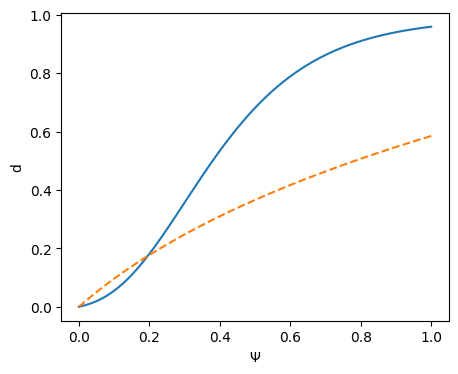

In [5]:
key, subkey = random.split(key)
params = init_params_damage(key)
Psi = jnp.linspace(0.0,1.0,100)
d_gt = d_Noel(Psi)
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(Psi, d_gt-d_gt[0])
d_pr = integrate_damage(params, Psi)
ax.plot(Psi, d_pr, '--')
ax.set(xlabel='$\Psi$', ylabel='d')

# Set up training

In [6]:
def loss_Noel(params):
    Psi = jnp.linspace(0.0,1.0,100)
    
    d_pr = integrate_damage(params, Psi)
    d_gt = d_Noel(Psi)
    return jnp.mean((d_pr-d_gt-d_gt[0])**2)

@partial(jit, static_argnums=(0,2,3,))
def step(loss, i, get_params, opt_update, opt_state):
    params = get_params(opt_state)
    g = grad(loss)(params)
    return opt_update(i, g, opt_state)

def train(loss, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000, metric_fns=None):
    train_loss = []
    metrics = []
    for it in range(nIter):
        key, subkey = random.split(key)
        opt_state = step(loss, it, get_params, opt_update, opt_state)         
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, metrics

In [7]:
params = init_params_damage(key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params)

# Train
params, train_loss, _ = train(loss_Noel, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=1000)

it 1000, train loss = 4.356522e-03
it 2000, train loss = 4.041098e-04
it 3000, train loss = 2.362632e-04
it 4000, train loss = 2.308147e-04
it 5000, train loss = 2.212716e-04
it 6000, train loss = 2.074794e-04
it 7000, train loss = 1.942389e-04
it 8000, train loss = 1.746772e-04
it 9000, train loss = 1.267732e-04
it 10000, train loss = 4.633243e-05
it 11000, train loss = 3.864289e-05
it 12000, train loss = 3.381724e-05
it 13000, train loss = 3.123999e-05
it 14000, train loss = 2.984845e-05
it 15000, train loss = 2.891295e-05
it 16000, train loss = 2.803686e-05
it 17000, train loss = 2.686408e-05
it 18000, train loss = 2.488206e-05
it 19000, train loss = 2.281065e-05
it 20000, train loss = 2.109998e-05
it 21000, train loss = 1.953381e-05
it 22000, train loss = 1.805640e-05
it 23000, train loss = 1.678857e-05
it 24000, train loss = 1.579659e-05
it 25000, train loss = 1.504591e-05
it 26000, train loss = 1.447430e-05
it 27000, train loss = 1.406482e-05
it 28000, train loss = 1.380052e-05
i

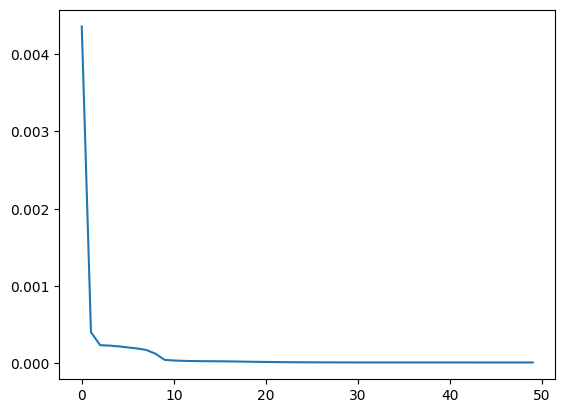

In [8]:
plt.plot(train_loss)

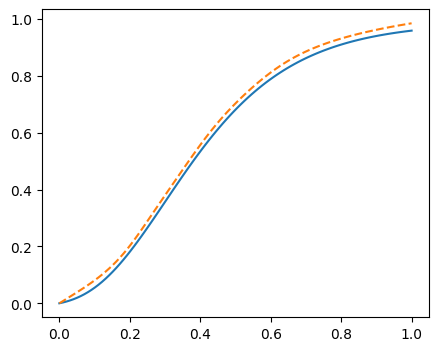

In [9]:
Psi = jnp.linspace(0.0,1.0,100)
d_pr = integrate_damage(params, Psi)
d_gt = d_Noel(Psi)
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(Psi, d_gt-d_gt[0])
ax.plot(Psi, d_pr, '--')